# 환경 세팅 및 라이브러리 불러오기

## 0. SKT 제공 Kobert pre-trained 모델 불러오기

In [17]:
!pip install "git+https://github.com/SKTBrain/KoBERT.git@master#egg=kobert_tokenizer&subdirectory=kobert_hf"

  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git 'C:\Users\user\AppData\Local\Temp\pip-install-sbp552wz\kobert-tokenizer_4cdb81d3c05a42fa8f8d38f391a79c7f'



  Cloning https://github.com/SKTBrain/KoBERT.git (to revision master) to c:\users\user\appdata\local\temp\pip-install-sbp552wz\kobert-tokenizer_4cdb81d3c05a42fa8f8d38f391a79c7f
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


## 1. 라이브러리 불러오기
***라이브러리 간 dependency conflict 주의***
- python==3.7
- mxnet==1.7.0.post2
- gluonnlp==0.10.0
- numpy==1.6.6
- pandas==1.0.0
- transformers==4.1.1
- scikit-learn = 3.1.2
- matplotlib==3.4.2
- pygame==3.8.1
- speech_recognition==3.8.1
- torch는 로컬 CPU 활용(pip3 install torch torchvision torchaudio) / 추후 cuda 활용 GPU 전환

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import sentencepiece
import gluonnlp as nlp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

## 1-1. Hugging Face에서 모델 불러오기

In [2]:
# Hugging Face를 통한 모델 및 토크나이저 Import
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [3]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1', last_hidden_states=True)
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

In [4]:
# tokenizer test
inputs = tokenizer("tokenizer 확인하기", return_tensors="pt")
inputs

{'input_ids': tensor([[   2,  709,  415,  392,  405,  459,  394, 5130, 7789,    3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

# 2. 데이터 전처리

In [5]:
total_data = pd.read_csv("D:\kobert\data\콜센터(식품) 메인 분석용 데이터.csv", encoding='utf-8')
total_data.head()

,IDX,발화자,발화문,카테고리,QA번호,QA여부,감성,인텐트 (대),인텐트 (중),인텐트 (소),...,수량(수치),크기,장소,조직,사람,시간,날짜,상품명,상담번호,상담내순번
0,1,c,컵밥 2만원 이상을 사면 무료 배송으로 아는데 여기가 죽도 추가로 몇 개 더 주문해...,식품,46175,q,m,배송,비용,질문,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,컵밥|죽,46175,1
1,2,s,박스에 합포가 되지 않을 수도 있어 정확한 답변 드리지 못하는 점 양해 부탁드립니다.,식품,46175,a,m,배송,비용,질문,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46175,2
2,3,c,해마로 기준 6개 이상이고 볶음밥 기준으로는 50개 이상인데 해마로 케이준 1봉과 ...,식품,40543,q,m,배송,비용,질문,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,해마로|볶음밥,40543,1
3,4,s,일단 두 제품이 같이 담기면 최소 수량 부과인 6개 이상은 시스템 상 자동부과가 됩니다.,식품,40543,a,m,배송,비용,질문,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40543,2
4,5,c,마트 원데이는 무료 배송이라고 되있는데 왜 결제를 하려고 하니까 배송비 3000원이...,식품,15426,q,m,배송,비용,질문,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15426,1


In [6]:
total_data.columns

Index(['IDX', '발화자', '발화문', '카테고리', 'QA번호', 'QA여부', '감성', '인텐트 (대)',
       ' 인텐트 (중)', '인텐트 (소)', '가격', '가격(수치)', '수량', '수량(수치)', '크기', '장소', '조직',
       '사람', '시간', '날짜', '상품명', '상담번호', '상담내순번'],
      dtype='object')

In [7]:
# 컬럼명 변경
total_data.rename(columns={"인텐트 (대)": "대분류"}, inplace=True)

In [8]:
# question만 추출
question=total_data[total_data["QA여부"]=="q"]
question.head()

,IDX,발화자,발화문,카테고리,QA번호,QA여부,감성,대분류,인텐트 (중),인텐트 (소),...,수량(수치),크기,장소,조직,사람,시간,날짜,상품명,상담번호,상담내순번
0,1,c,컵밥 2만원 이상을 사면 무료 배송으로 아는데 여기가 죽도 추가로 몇 개 더 주문해...,식품,46175,q,m,배송,비용,질문,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,컵밥|죽,46175,1
2,3,c,해마로 기준 6개 이상이고 볶음밥 기준으로는 50개 이상인데 해마로 케이준 1봉과 ...,식품,40543,q,m,배송,비용,질문,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,해마로|볶음밥,40543,1
4,5,c,마트 원데이는 무료 배송이라고 되있는데 왜 결제를 하려고 하니까 배송비 3000원이...,식품,15426,q,m,배송,비용,질문,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15426,1
6,7,c,제주도 추가 배송료 잇나요?,식품,226944,q,m,배송,비용,질문,...,NaN,NaN,제주도,NaN,NaN,NaN,NaN,NaN,226944,1
8,9,c,물건이 오지도 않았는데 취소하게 되면 3천원이 빠지더라구 요 반품 택배사원이 오는 ...,식품,229560,q,n,배송,비용,질문,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,229560,1


In [9]:
# 필요 컬럼 추출(질문만 추출하기)
data = question[["발화문", "대분류"]]
data.head()

,발화문,대분류
0,컵밥 2만원 이상을 사면 무료 배송으로 아는데 여기가 죽도 추가로 몇 개 더 주문해...,배송
2,해마로 기준 6개 이상이고 볶음밥 기준으로는 50개 이상인데 해마로 케이준 1봉과 ...,배송
4,마트 원데이는 무료 배송이라고 되있는데 왜 결제를 하려고 하니까 배송비 3000원이...,배송
6,제주도 추가 배송료 잇나요?,배송
8,물건이 오지도 않았는데 취소하게 되면 3천원이 빠지더라구 요 반품 택배사원이 오는 ...,배송


In [10]:
data["대분류"].value_counts()

제품          103929
배송           92034
행사            7192
포장            4352
결제            3961
교환|반품|환불      3552
웹사이트          1040
AS             952
멤버십            144
Name: 대분류, dtype: int64

In [11]:
# 기타 열 만들기(교환|반품|환불부터 웹사이트까지)
df = data.copy()
df.loc[df['대분류'].isin(['교환|반품|환불', 'AS', '멤버십', '웹사이트']), '대분류'] = '기타'
df["대분류"].value_counts()

제품    103929
배송     92034
행사      7192
기타      5688
포장      4352
결제      3961
Name: 대분류, dtype: int64

In [12]:
# 정수 인코딩
df['대분류'] = pd.factorize(df['대분류'])[0]
df.head()

,발화문,대분류
0,컵밥 2만원 이상을 사면 무료 배송으로 아는데 여기가 죽도 추가로 몇 개 더 주문해...,0
2,해마로 기준 6개 이상이고 볶음밥 기준으로는 50개 이상인데 해마로 케이준 1봉과 ...,0
4,마트 원데이는 무료 배송이라고 되있는데 왜 결제를 하려고 하니까 배송비 3000원이...,0
6,제주도 추가 배송료 잇나요?,0
8,물건이 오지도 않았는데 취소하게 되면 3천원이 빠지더라구 요 반품 택배사원이 오는 ...,0


**3900개(실제 분석용)**

In [13]:
# 3900개씩 데이터 추출하기
df = df.groupby("대분류", group_keys=False).apply(lambda x: x.sample(n=3900, replace=False, random_state=0)).reset_index(drop=True)
df["대분류"].value_counts()

5    3900
4    3900
3    3900
2    3900
1    3900
0    3900
Name: 대분류, dtype: int64

**500개(테스트용)**

In [ ]:
# 테스트용 500개씩 추출하기
df = df.groupby("대분류", group_keys=False).apply(lambda x: x.sample(n=500, replace=False, random_state=0)).reset_index(drop=True)
df["대분류"].value_counts()

5    500
3    500
1    500
4    500
2    500
0    500
Name: 대분류, dtype: int64

In [14]:
# 학습에 활용할 데이터 개수
print("학습 데이터 개수 : ",df.shape)
df.head()

학습 데이터 개수 :  (23400, 2)


,발화문,대분류
0,화요일날 주문한 건데 왜 취소된 건가요?,0
1,20일 금요일에 받고 싶은데 출고일은 언제하면 되나요?,0
2,묶음배송 안 되는 겁니까?,0
3,내일 받을 수 있는 거죠?,0
4,오늘 주문하면 언제 받을 수 있을까요?,0


# 3. 학습 위해 데이터 분할하기(훈련, 검증, 테스트)

In [15]:
# 리스트 형태로 만들어서 훈련을 위한 데이터셋 확보
data_list = []
for sent, label in zip(df['발화문'], df['대분류'])  :
    data = []
    data.append(sent)
    data.append(str(label))

    data_list.append(data)

In [16]:
# 데이터 확인하기(실전용)
print(data_list[0])
print(data_list[5000])
print(data_list[10000])
print(data_list[13000])
print(data_list[16000])
print(data_list[21000])

['화요일날 주문한 건데 왜 취소된 건가요?', '0']
['주문할려고 하는데 1, 2, 10, 11호 유통기한이 어떻게 되나요?', '1']
['언제 구매 가능한가요?', '2']
['선물용이라서 박스별로 담을 수 있는 쇼핑백 같은 게 같이 오나요?', '3']
['밀떡, 누들떡 하나씩 주문했는데, 밀떡으로만 보내시면 어쩌나요?', '4']
['아직 받진 못했는데 모닝인 텐소 1+1이라고 적혀 있을 때 샀는데, 다른 사람들 문의랑 답변 보니까 오류난 거고 원래 2+1이라고 하시네요?', '5']


In [17]:
X = df.drop('대분류', axis=1)
y = df['대분류']

In [18]:
# 훈련, 테스트용으로 데이터 분할하기(대분류의 비율에 맞춰 분할하기)
dataset_train, dataset_test = train_test_split(data_list, test_size=0.25, random_state=0, stratify=y)

In [19]:
dataset_train[0]

['며칠 전 구매했는데요주소 적용을 잘못하는 바람에 암튼 재구매하려 구하는데요중복 15프로 할인 쿠폰은 어디에 있나요?', '2']

# 4. KoBERT 입력 데이터로 만들기

In [20]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [21]:
# 파라미터 세팅
max_len = 64
batch_size = 32
warmup_ratio = 0.1
num_epochs = 20
# num_epochs = 5 # 테스트용
max_grad_norm = 2
log_interval = 200
learning_rate = 2e-5

In [22]:
tok = tokenizer.tokenize

data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, vocab, max_len, True, False)

In [23]:
print(data_train[0])

(array([   2,  517, 6197, 7490, 4012, 1119, 7867, 6999, 7276, 6607, 4004,
       7088, 3943, 7794, 2195, 6896, 3177, 7668, 3969, 5495, 6168, 7806,
       1115, 7795, 6999, 7295, 6379,  543, 7755, 4981, 4680, 7736, 7086,
       3223, 6896, 3854, 5655, 6999,  258,    3,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1]), array(40), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 2)


In [24]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=0) # 로컬에서 돌릴 경우 코어 수에 맞게 num_workers 설정
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=0) # 로컬에서 돌릴 경우 코어 수에 맞게 num_workers 설정

# 5.KoBERT 학습모델 만들기

In [25]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6,   # 대분류가 6개
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [26]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

# 6.KoBERT 모델 학습시키기

In [29]:
train_acc_history = []
test_acc_history = []
train_loss_history = []
best_test_acc = 0.0
patience = 2  # 향상을 기다릴 epoch 수

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long()
        segment_ids = segment_ids.long()
        valid_length= valid_length
        label = label.long()
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        train_acc += calc_accuracy(out, label)
        train_loss += loss.item()
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}\n".format(e+1, train_acc / (batch_id+1)))
    train_acc_history.append(train_acc / (batch_id + 1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long()
        segment_ids = segment_ids.long()
        valid_length= valid_length
        label = label.long()
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_acc_value = test_acc / (batch_id + 1)
    test_acc_history.append(test_acc_value)
    train_loss_history.append(train_loss / (batch_id + 1))

    # 과적합 위험 방지 위해 조기 종료 기능 추가
    if test_acc > best_test_acc :
      best_test_acc = test_acc
      patience_counter = 0
      print(f"{e+1}번째 epoch에서 학습이 성공적으로 진행됐습니다.\n")
    else :
      patience_counter += 1
      print(f"{e+1}번째 epoch에서 정확도 개선이 이뤄지지 않아 다시 한번 학습을 실시합니다.\n")

    if patience_counter >= patience :
        print(f"{e+1}번째 epoch에서 더 이상 테스트 정확도가 개선되지 않아 학습을 중단합니다.\n")
        break

  0%|▏                                                                                 | 1/549 [00:01<15:49,  1.73s/it]

epoch 1 batch id 1 loss 2.020388603210449 train acc 0.125


 37%|█████████████████████████████▎                                                  | 201/549 [05:48<10:15,  1.77s/it]

epoch 1 batch id 201 loss 1.7574479579925537 train acc 0.2126865671641791


 73%|██████████████████████████████████████████████████████████▍                     | 401/549 [11:39<04:22,  1.77s/it]

epoch 1 batch id 401 loss 1.077832818031311 train acc 0.4123285536159601


100%|████████████████████████████████████████████████████████████████████████████████| 549/549 [16:02<00:00,  1.75s/it]


epoch 1 train acc 0.5146532656778557



100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [01:38<00:00,  1.85it/s]


epoch 1 test acc 0.7985892181588904
1번째 epoch에서 학습이 성공적으로 진행됐습니다.



  0%|▏                                                                                 | 1/549 [00:01<16:27,  1.80s/it]

epoch 2 batch id 1 loss 0.6580504775047302 train acc 0.75


 37%|█████████████████████████████▎                                                  | 201/549 [05:52<10:13,  1.76s/it]

epoch 2 batch id 201 loss 0.8213684558868408 train acc 0.7966417910447762


 73%|██████████████████████████████████████████████████████████▍                     | 401/549 [11:42<04:21,  1.76s/it]

epoch 2 batch id 401 loss 0.898033082485199 train acc 0.8083697007481296


100%|████████████████████████████████████████████████████████████████████████████████| 549/549 [16:04<00:00,  1.76s/it]


epoch 2 train acc 0.8154517954722873



100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [01:38<00:00,  1.86it/s]


epoch 2 test acc 0.8173339638503573
2번째 epoch에서 학습이 성공적으로 진행됐습니다.



  0%|▏                                                                                 | 1/549 [00:01<16:35,  1.82s/it]

epoch 3 batch id 1 loss 0.39713647961616516 train acc 0.875


 37%|█████████████████████████████▎                                                  | 201/549 [05:55<10:13,  1.76s/it]

epoch 3 batch id 201 loss 0.6049259901046753 train acc 0.8421952736318408


 73%|██████████████████████████████████████████████████████████▍                     | 401/549 [11:44<04:18,  1.74s/it]

epoch 3 batch id 401 loss 0.5272362232208252 train acc 0.8531795511221946


100%|████████████████████████████████████████████████████████████████████████████████| 549/549 [16:02<00:00,  1.75s/it]


epoch 3 train acc 0.8598669659120478



100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [01:36<00:00,  1.89it/s]


epoch 3 test acc 0.8122504203446826
3번째 epoch에서 정확도 개선이 이뤄지지 않아 다시 한번 학습을 실시합니다.



  0%|▏                                                                                 | 1/549 [00:01<16:42,  1.83s/it]

epoch 4 batch id 1 loss 0.4411305785179138 train acc 0.78125


 37%|█████████████████████████████▎                                                  | 201/549 [05:51<10:04,  1.74s/it]

epoch 4 batch id 201 loss 0.5876891016960144 train acc 0.8781094527363185


 73%|██████████████████████████████████████████████████████████▍                     | 401/549 [11:41<04:18,  1.74s/it]

epoch 4 batch id 401 loss 0.2994328737258911 train acc 0.8869233167082294


100%|████████████████████████████████████████████████████████████████████████████████| 549/549 [16:01<00:00,  1.75s/it]


epoch 4 train acc 0.8933694379391101



100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [01:38<00:00,  1.86it/s]

epoch 4 test acc 0.8096495376208491
4번째 epoch에서 정확도 개선이 이뤄지지 않아 다시 한번 학습을 실시합니다.

4번째 epoch에서 더 이상 테스트 정확도가 개선되지 않아 학습을 중단합니다.



## 6-1-1. Epoch별 정확도 차트

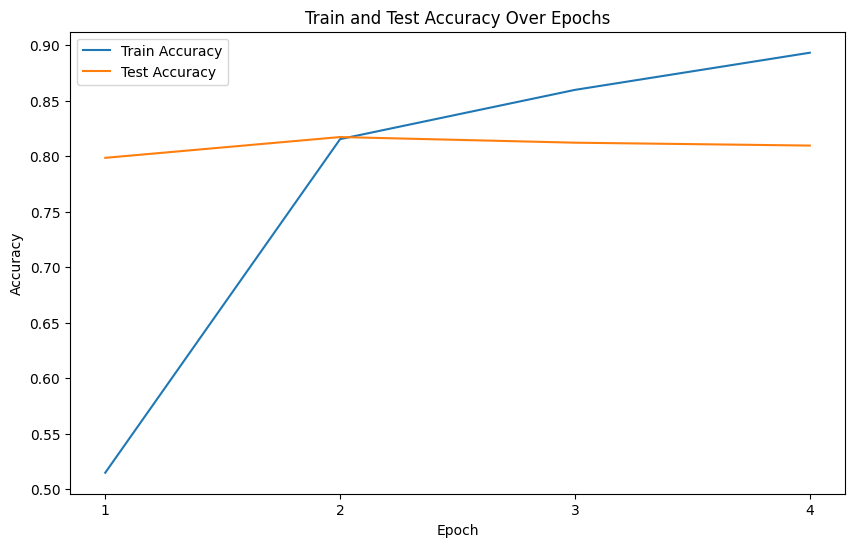

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label='Train Accuracy')
plt.plot(range(1, len(test_acc_history) + 1), test_acc_history, label='Test Accuracy')
plt.title('Train and Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(range(1, len(train_acc_history) + 1, 1))
plt.show()

## 6-1-2. Epoch별 손실 차트

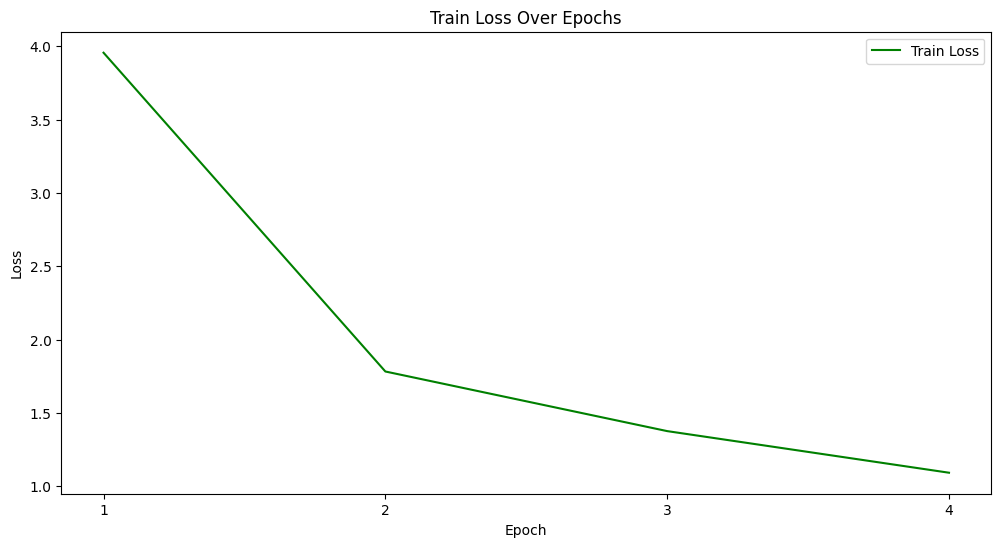

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.xticks(range(1, len(train_loss_history) + 1, 1))
plt.show()

## 6-2. 모델 저장

In [32]:
# 디렉토리 생성
directory = "D:\kobert\model"
os.makedirs(directory, exist_ok=True)

# 모델 저장
model_save_name = 'trained_kobert_model_1227.pt'
path = os.path.join(directory, model_save_name)
torch.save(model.state_dict(), path)

In [27]:
# 훈련이 완료된 모델 불러오기
directory = "D:\kobert\model"
model_save_name = 'trained_kobert_model_1227.pt'
path = os.path.join(directory, model_save_name)

model = BERTClassifier(bertmodel, dr_rate=0.5)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# 7.새로운 문장 테스트

In [113]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=0) # 로컬에서 돌릴 경우 코어 수에 맞게 num_workers 설정

    model.eval()
    results = []
    
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long()
        segment_ids = segment_ids.long()

        valid_length= valid_length
        label = label.long()

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("'배송'")
            elif np.argmax(logits) == 1:
                test_eval.append("'제품'")
            elif np.argmax(logits) == 2:
                test_eval.append("'결제'")
            elif np.argmax(logits) == 3:
                test_eval.append("'포장'")
            elif np.argmax(logits) == 4:
                test_eval.append("'기타'")
            elif np.argmax(logits) == 5:
                test_eval.append("'행사'")
        results.append(test_eval[0])

        print(">> 해당 발화문은 " + test_eval[0] + " 대분류에 해당합니다.")
    return results

In [103]:
#질문 무한반복 / 종료'라고 입력시 종료
end = 1
while end == 1 :
    sentence = input("발화문을 입력하시오. : ")
    if sentence == "종료" :
        break
    results = predict(sentence)
    print("\n")

발화문을 입력하시오. : 울릉도도 배송이 되나요?
>> 입력하신 발화문은 '배송' 대분류에 해당합니다.


발화문을 입력하시오. : 종료


# 음성 인식 ARS 만들기

In [31]:
# 음성 인식용 라이브러리 불러오기
import time
import speech_recognition as sr
import pygame

pygame 2.5.2 (SDL 2.28.3, Python 3.7.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [32]:
# 컴퓨터 내장 음성 재생 모듈
def playAudio(file_path):
    pygame.init()
    pygame.mixer.init()

    try:
        pygame.mixer.music.load(file_path)
        pygame.mixer.music.play()

        # 음악이 재생 중인 동안 대기
        while pygame.mixer.music.get_busy():
            pygame.time.Clock().tick(10)

    except pygame.error as e:
        print(f"음성 파일 재생 중 오류 발생: {str(e)}")

    pygame.quit()

In [147]:
info_1 = "D:/kobert/안내문모음/01_안녕하세요.mp3"
info_2 = "D:/kobert/안내문모음/02_죄송합니다.mp3"
info_3 = "D:/kobert/안내문모음/03_죄송(2).mp3"
info_product = "D:/kobert/안내문모음/03_제품.mp3"
info_delivery ="D:/kobert/안내문모음/04_배송.mp3"
info_credit = "D:/kobert/안내문모음/05_결제.mp3" 
info_event = "D:/kobert/안내문모음/06_행사.mp3"
info_etc = "D:/kobert/안내문모음/07_기타.mp3"
info_package = "D:/kobert/안내문모음/08_포장.mp3"

In [148]:
# 예시로 재생
playAudio(info_3)

In [123]:
# 음성 녹음 함수
def voiceRecog(num, timeout=3):
    r = sr.Recognizer()
    print("안녕하세요. 오뚜기 주문센터입니다. 음성 ARS 서비스에 연결되었습니다. \n빠른 서비스를 제공하기 위해 문의 내용을 말씀해주시면 곧바로 해당 부서로 연결해드리겠습니다. 문의 내용을 자유롭게 말씀해주세요.")
    playAudio(info_1)
    start_time = time.time()
    while True:
        try:
            with sr.Microphone() as source:
                if time.time() - start_time < num:
                    audio = r.listen(source)
                else:
                    audio = r.listen(source, timeout=timeout)

                # 음성을 텍스트로 변환
                recognized_text = r.recognize_google(audio, language='ko-KR')
                return recognized_text
        except sr.UnknownValueError:
            print("죄송합니다. 다시 한번 문의 내용을 말씀해주시면 신속히 도움을 드리겠습니다.")
            playAudio(info_3)
            # 응답 시간이 초과된 경우에도 num 초 이상 경과하면 함수 종료
            if time.time() - start_time > num:
                continue
        except sr.WaitTimeoutError : 
            print("죄송합니다. 응답 시간이 초과되었습니다. 다시 한번 문의 내용을 말씀해주시면 신속히 도움을 드리겠습니다.")
            playAudio(info_2)
            if time.time() - start_time > num:
                continue

In [117]:
customer_input = voiceRecog(5)
print(customer_input)

안녕하세요. 오뚜기 주문센터입니다. 음성 ARS 서비스에 연결되었습니다. 
빠른 서비스를 제공하기 위해 문의 내용을 말씀해주시면 곧바로 해당 부서로 연결해드리겠습니다. 문의 내용을 자유롭게 말씀해주세요.
울릉도도 배송이 가능한가요


In [109]:
predict(customer_input)

["'배송'"]

In [110]:
results[0]

"'배송'"

In [146]:
#질문 무한반복 / 종료라고 음성 입력 시 종료

end = 1
while end == 1 :
    customer_input = voiceRecog(5)
    print("\n")
    print("사용자 문의 : ", customer_input)
    
    if customer_input == "종료" :
        break
    results = predict(customer_input)
    if results[0] == "'배송'" :
        print("배송 관련 부서로 전화 연결 도와드리겠습니다. 상담원을 연결합니다.")
        playAudio(info_delivery)
        break
    elif results[0] == "'제품'" :
        print("제품 관련 부서로 전화 연결 도와드리겠습니다. 상담원을 연결합니다.")
        playAudio(info_product)
        break
    elif results[0] == "'결제'" :
        print("결제 관련 부서로 전화 연결 도와드리겠습니다. 상담원을 연결합니다.")
        playAudio(info_credit)
        break
    elif results[0] == "'포장'" :
        print("포장 관련 부서로 전화 연결 도와드리겠습니다. 상담원을 연결합니다.")
        playAudio(info_package)
        break
    elif results[0] == "'기타'" :
        print("기타 관련 부서로 전화 연결 도와드리겠습니다. 상담원을 연결합니다.")
        playAudio(info_etc)
        break
    elif results[0] == "'행사'" :
        print("행사 관련 부서로 전화 연결 도와드리겠습니다. 상담원을 연결합니다.")
        playAudio(info_event)
        break
    print("\n")

안녕하세요. 오뚜기 주문센터입니다. 음성 ARS 서비스에 연결되었습니다. 
빠른 서비스를 제공하기 위해 문의 내용을 말씀해주시면 곧바로 해당 부서로 연결해드리겠습니다. 문의 내용을 자유롭게 말씀해주세요.


사용자 문의 :  울릉도도 배송이 되나요
>> 해당 발화문은 '배송' 대분류에 해당합니다.
배송 관련 부서로 전화 연결 도와드리겠습니다. 상담원을 연결합니다.
